In [7]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [6]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [8]:
pregion = 'southern'
#inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+pregion+'_cross_15UTC_1985-2018_peru.nc'
inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+pregion+'_perpendicular_15UTC_1985-2018_peru.nc'

In [9]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_1mm_3-7days_StartOfSpell.nc')
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_1mm_3-7days_StartOfSpell.nc')
dry_test.name = 'dry'
wet_test.name = 'wet'

In [10]:
ds = xr.open_dataset(inpath)

In [11]:
ds = ds.assign_coords({'index' : ds.longitude})

In [12]:
ds = ds.drop('longitude')

In [13]:
ds = ds.rename({'index' : 'longitude'})

In [14]:
ds

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 100, time: 6092)
Coordinates:
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 1986-03-23 1986-11-18 ... 2017-10-08
    latitude   (longitude) float64 ...
  * longitude  (longitude) float64 -73.5 -73.38 -73.26 ... -62.22 -62.11 -62.0
Data variables:
    d          (time, level, longitude) float64 ...
    z          (time, level, longitude) float64 ...
    r          (time, level, longitude) float64 ...
    q          (time, level, longitude) float64 ...
    t          (time, level, longitude) float64 ...
    u          (time, level, longitude) float64 ...
    v          (time, level, longitude) float64 ...
    w          (time, level, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-01 09:26:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [15]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-12)]}
h = 2000

In [16]:
region = pregion
spell_length = 3
alls = regions[region]

In [17]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [18]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')
hei = height['h'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
hei_perp = hei[0:100].copy(deep=True)

In [19]:
hei_val = []
for hin in ds.longitude:

    hind = ds.sel(longitude=hin)
    point = height.sel(latitude=hind.latitude, longitude=hind.longitude, method='nearest')
    hei_val.append(point)
height_perp = xr.concat(hei_val, dim='longitude')

In [20]:
z_val = []
for hin in ds.longitude:

    hind = ds.sel(longitude=hin)
    point = topo_full.sel(latitude=hind.latitude, longitude=hind.longitude, method='nearest')
    z_val.append(point)
z_perp = xr.concat(z_val, dim='longitude')

In [21]:
z_perp = z_perp.assign_coords({'longitude' : ds.longitude}).squeeze()
height_perp = height_perp.assign_coords({'longitude' : ds.longitude}).squeeze()

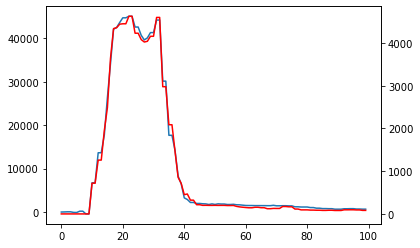

In [22]:
f = plt.figure()
ax = f.add_subplot(111)
ax1 = ax.twinx()
ax.plot(z_perp['z'])
ax1.plot(height_perp['h'], color='red')

In [23]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0, level=0)
dummy = uda.flip_lat(dummy)

In [24]:
dry = dummy.salem.transform(dry_test, interp='nearest').where(height>=2000)
wet = dummy.salem.transform(wet_test, interp='nearest').where(height>=2000)

In [25]:
ds_filtered = ds.drop('latitude')

In [26]:
ds_filtered = ds_filtered.load()

In [27]:
ds_filtered

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 100, time: 6092)
Coordinates:
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 1986-03-23 1986-11-18 ... 2017-10-08
  * longitude  (longitude) float64 -73.5 -73.38 -73.26 ... -62.22 -62.11 -62.0
Data variables:
    d          (time, level, longitude) float64 -4.383e-05 ... -6.618e-06
    z          (time, level, longitude) float64 1.221e+05 ... 3.418e+03
    r          (time, level, longitude) float64 90.8 96.3 98.39 ... 80.77 78.42
    q          (time, level, longitude) float64 6.283e-05 6.748e-05 ... 0.01621
    t          (time, level, longitude) float64 218.6 218.7 ... 298.1 298.3
    u          (time, level, longitude) float64 -1.82 -2.358 ... -0.3311 -0.4714
    v          (time, level, longitude) float64 -1.9 -2.307 ... -2.719 -2.699
    w          (time, level, longitude) float64 0.0625 0.05116 ... -0.04674
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-01 09:26:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

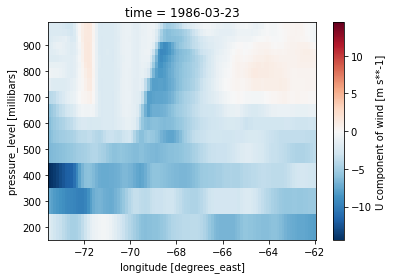

In [28]:
ds_filtered['u'].isel(time=0).plot()

In [29]:
ds_filtered = ds_filtered.where(ds['z']>z_perp['z'])
#ds_filtered = ds_filtered.where(ds['z']>z['z'])

In [30]:
ds_filtered = ds_filtered.sel(time=ds_filtered['time.year']>=2000)

In [31]:
def get_spells(spell_ds,alls,spell_length,era_times, equal=None, gt=None):
    
    mask = 0
    if gt is not None:
        mask = spell_ds >= spell_length
    if equal is not None:
        mask = spell_ds == spell_length
    
    #ipdb.set_trace()
    dry_region = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(mask).count('latitude').squeeze()
    dry_region_all = spell_ds['h'].sel(latitude=slice(alls[0][0], alls[0][1])).where(np.isfinite(spell_ds)).count('latitude').squeeze()
    #ipdb.set_trace()
    dry_dates = dry_region.where((dry_region.mean(['longitude'])/dry_region_all.mean(['longitude'])>0.15), drop=True)  # fraction covered by spell, 0.25 means 25% of pixels on day
    
    drydates = []
    for edates in era_times:
        dpos = np.where(edates.values == dry_dates.time.values)
        #ipdb.set_trace()
        if np.sum(dpos)>0:
            #ipdb.set_trace()
            drydates.append(pd.Timestamp(dry_dates.time.values[dpos][0]))
    return pd.to_datetime(drydates)

In [32]:
drydates = get_spells(dry,alls,3,ds_filtered.time, equal=True)

In [33]:
wetdates = get_spells(wet,alls,3,ds_filtered.time, equal=True)

In [34]:
drydates7 = get_spells(dry,alls,5,ds_filtered.time, gt=True)

In [35]:
wetdates7 = get_spells(wet,alls,5,ds_filtered.time, gt=True)

In [36]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.8, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    ax.set_ylim(170,1000)
    #ax.set_xlim(-81.5,-60)
   # ax.set_xlim(-81.5,-72.5)
    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    #ax.set_yticklabels(np.arange(1000, 50, -100))
    
    #ax.set_yticks(np.arange(1000, 50, -100))
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002, headwidth=7)
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=1 )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp

In [37]:
dds = drydates #-pd.Timedelta('1days')
wds = wetdates #-pd.Timedelta('1days')
dds7 = drydates7 #-pd.Timedelta('1days')
wds7 = wetdates7# -pd.Timedelta('1days')

slices_dry = ds_filtered.sel(time=dds).mean('time') # drymean
slices_wet = ds_filtered.sel(time=wds).mean('time') # wetmean
sli_dry = ds_filtered.sel(time=dds)#.mean('time') # alldry
sli_wet = ds_filtered.sel(time=wds)#.mean('time') # allwet

In [38]:
ds

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 100, time: 6092)
Coordinates:
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 1986-03-23 1986-11-18 ... 2017-10-08
    latitude   (longitude) float64 -17.9 -17.79 -17.69 ... -7.224 -7.112 -7.0
  * longitude  (longitude) float64 -73.5 -73.38 -73.26 ... -62.22 -62.11 -62.0
Data variables:
    d          (time, level, longitude) float64 -4.383e-05 ... -6.618e-06
    z          (time, level, longitude) float64 1.221e+05 ... 3.418e+03
    r          (time, level, longitude) float64 90.8 96.3 98.39 ... 80.77 78.42
    q          (time, level, longitude) float64 6.283e-05 6.748e-05 ... 0.01621
    t          (time, level, longitude) float64 218.6 218.7 ... 298.1 298.3
    u          (time, level, longitude) float64 -1.82 -2.358 ... -0.3311 -0.4714
    v          (time, level, longitude) float64 -1.9 -2.307 ... -2.719 -2.699
    w          (time, level, longitude) float64 0.0625 0.05116 ... -0.04674
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-01 09:26:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [39]:
def calc_from_era(ds):
    pdub = np.array([list(ds.level.values),]*len(ds.longitude)).T
    p = units.Quantity(pdub, 'hPa')
    #print(p)
    t = units.Quantity(ds['t'].values, 'K')
    q = units.Quantity(ds['q'].values, 'kg/kg')
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    #ipdb.set_trace()
    theta_es = np.array(calc.saturation_equivalent_potential_temperature(p,t))#-273.15
    theta_e = np.array(calc.equivalent_potential_temperature(p,t,dew))#-273.15
    theta = np.array(calc.potential_temperature(p,t))
    theta_e_mine = u_met.theta_e(ds.level.values, ds['t'].values-273.15, ds['q'].values)+273.15
    
    tes = ds['q'].copy(deep=True)
    te = ds['q'].copy(deep=True)
    tem = ds['q'].copy(deep=True)
    th = ds['q'].copy(deep=True)
    
    tes.values = theta_es
    te.values = theta_e
    tem.values = theta_e_mine
    th.values = theta
    ds['theta_es'] = tes
    ds['theta_e'] = te
    ds['theta_em'] = tem
    ds['theta'] = th

    return ds#theta_es, theta_e, theta_e_mine

In [40]:
slices_dry = calc_from_era(slices_dry)
slices_wet = calc_from_era(slices_wet)

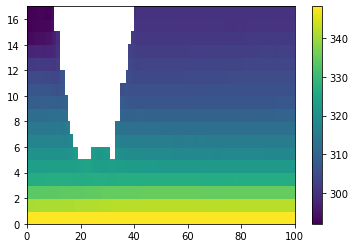

In [41]:
plt.pcolormesh(slices_dry['theta'])
plt.colorbar()

In [42]:
slices_all_dryclim = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear') # dayofyear clim drydays
slices_all_wetclim = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear') # dayofyear clim wetdays
slices_all_dryclim7 = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds7.dayofyear)).mean('dayofyear') # dayofyear clim drydays 7d
slices_all_wetclim7 = ds_filtered.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds7.dayofyear)).mean('dayofyear') # dayofyear clim wetdays 7d

slices_all = ds_filtered.mean('time') # fullclim
sli_all = ds_filtered # allcases

In [43]:
slices_dry7 = ds_filtered.sel(time=dds7).mean('time') # drymean 7days
slices_wet7 = ds_filtered.sel(time=wds7).mean('time') # wetmean 7days
sli_dry7 = ds_filtered.sel(time=dds7)#.mean('time') # alldry 7days
sli_wet7 = ds_filtered.sel(time=wds7)#.mean('time') # allwet 7days

In [44]:
slices_all_dryclim = calc_from_era(slices_all_dryclim)
slices_all_wetclim = calc_from_era(slices_all_wetclim)
slices_all_dryclim7 = calc_from_era(slices_all_dryclim7)
slices_all_wetclim7 = calc_from_era(slices_all_wetclim7)
slices_all = calc_from_era(slices_all)
slices_dry7 = calc_from_era(slices_dry7)
slices_wet7 = calc_from_era(slices_wet7)

In [45]:
slices_months = [('3 dry',slices_dry, sli_dry, slices_all_dryclim), ('3 wet',slices_wet, sli_wet, slices_all_wetclim), ('>5 dry', slices_dry7, sli_dry7, slices_all_dryclim7), ('>5 wet', slices_wet7, sli_wet7, slices_all_wetclim7)]

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: The following kwargs were not used by contour: 'linewidth'


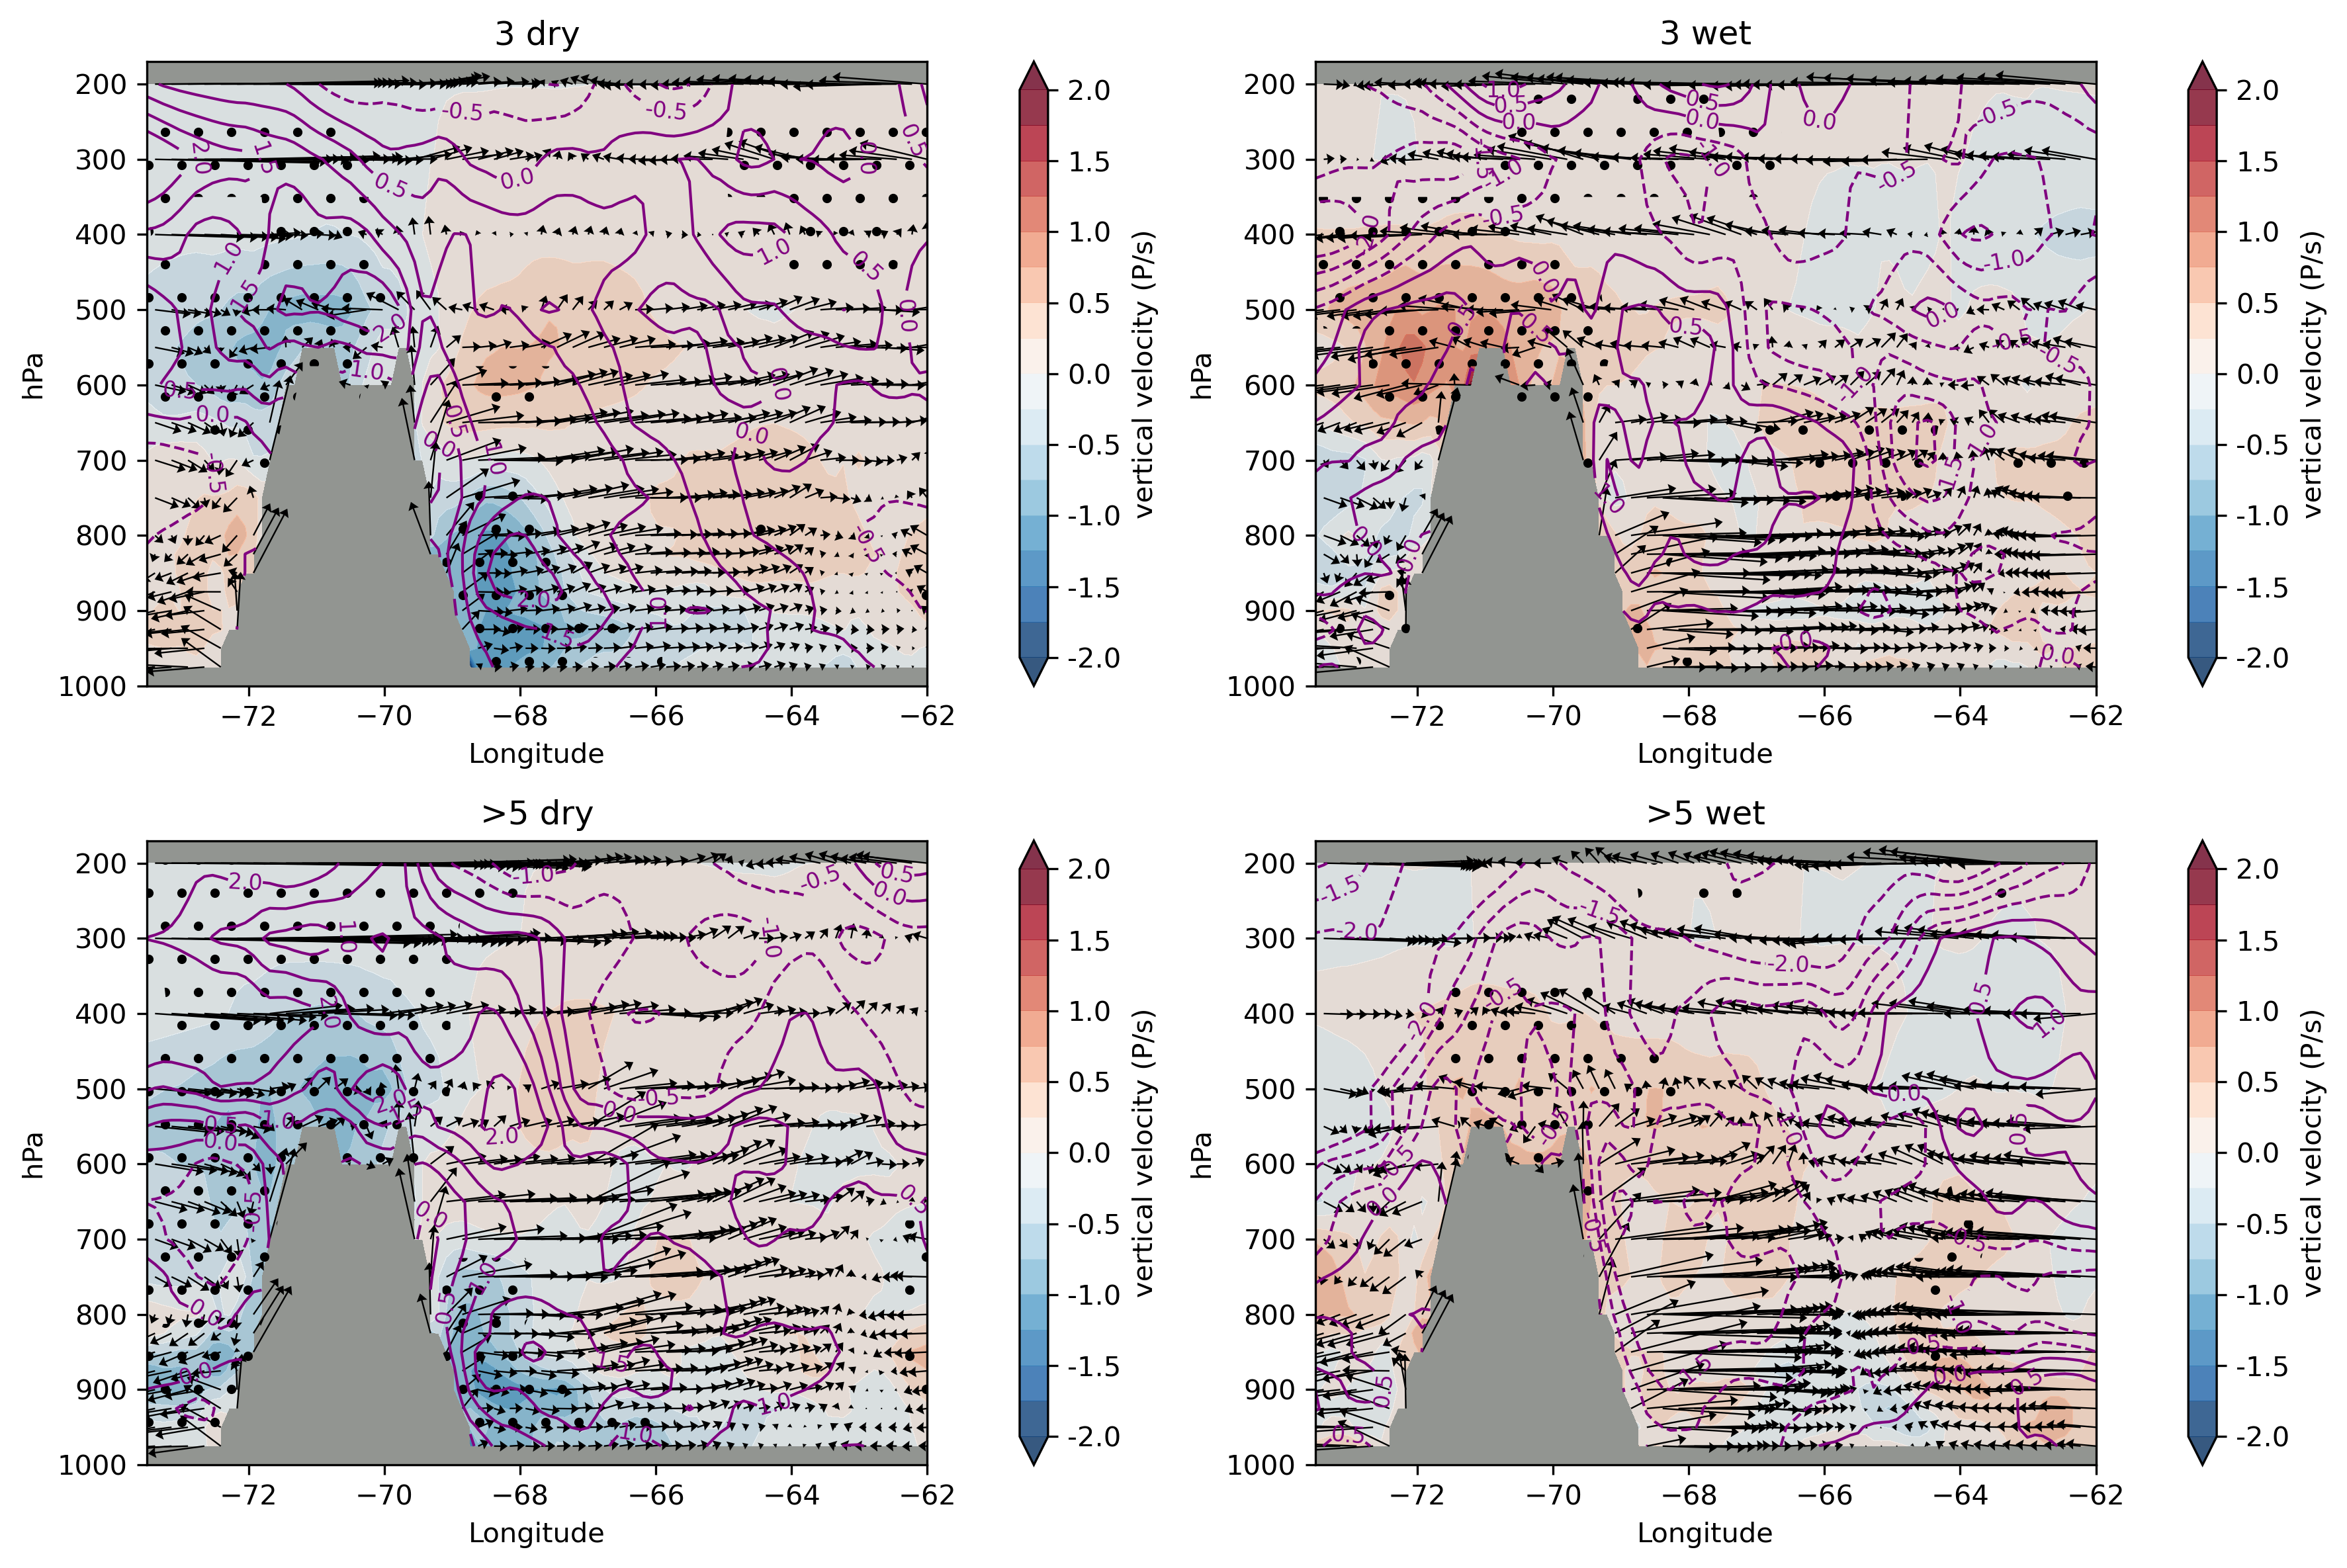

In [46]:
f = plt.figure(figsize=(12,8), dpi=300)

for ids, tt in enumerate([11,12,1,3,]):
    
    slices = slices_months[ids][1] # d/w mean
    tag = slices_months[ids][0]
    sli = slices#.isel(month=()) # d/w mean
    slices_ttest = slices_months[ids][2] #  d/w all, for day-wise t-test, all days versus only wet/dry
    slice_clim = slices_months[ids][3] # doy d/w clim

#     p = units.Quantity(sli.level.values, 'hPa')

#     t = units.Quantity(sli['t'].values, 'K')
#     q = units.Quantity(sli['q'].values, 'kg/kg')


#     dewp = calc.dewpoint_from_specific_humidity(q.T, t.T, p).T
#     theta_e = calc.equivalent_potential_temperature(p,t.T,dewp.T).T
#     theta = calc.potential_temperature(p,t.T).T

    # "current zonal wind" wind vectors
    vano = sli['u']
    wano = sli['w']*(-5)  # multiplied by 10 since vertical component is very small compared to horizontal one
    vclim = slice_clim['u']
    wclim = slice_clim['w']*(-5)
    st=2
    sarrow = 1
    xquiv = sli.longitude[sarrow::st]
    yquiv = sli.level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]
    uuc = (vclim)[::, sarrow::st]  
    wwc = (wclim)[::, sarrow::st]  

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 40}

    # temperature and moisture check
    #data = (np.array(theta.data).T-np.nanmean(theta.data, axis=1)).T
    var = 'q'
    var2 = 'q'
    a = slices_ttest[var2] #* slices_ttest['q'] # for day-wise t-test
    b = sli_all[var2] #* sli_all['q']
    tstat, pval = stats.ttest_ind(a, b, axis=0)
    mask = pval<=0.05
    data2 = (slices[var]-slice_clim[var])*1000
    #ipdb.set_trace()
    data = (slices['v']-slice_clim['v'])
    ax = f.add_subplot(2,2,ids+1)
    
    contour = {'data' : data, 'x' :sli.longitude, 'y' : sli.level, 'levels' : np.arange(-2,2.1,0.5), 'colours' : 'purple'}  #np.arange(335,355, 1)
    draw_cross(ax, data2, sli.longitude, sli.level, ylabel = 'hPa', xlabel='Longitude',cmap='RdBu_r', quiver=qin, contour=contour, cbar_label='vertical velocity (P/s)', levels=np.arange(-2, 2.1, 0.25), title=tag)  #Spectral
    
    ax.contourf(sli.longitude, sli.level, mask, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    #ax.set_xlim(-80,-68)
    ax.set_facecolor('xkcd:grey')
    plt.tight_layout()
    f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/cross/'+var+'_drywet_perpendicular_'+pregion+'_DoyClim.jpg')


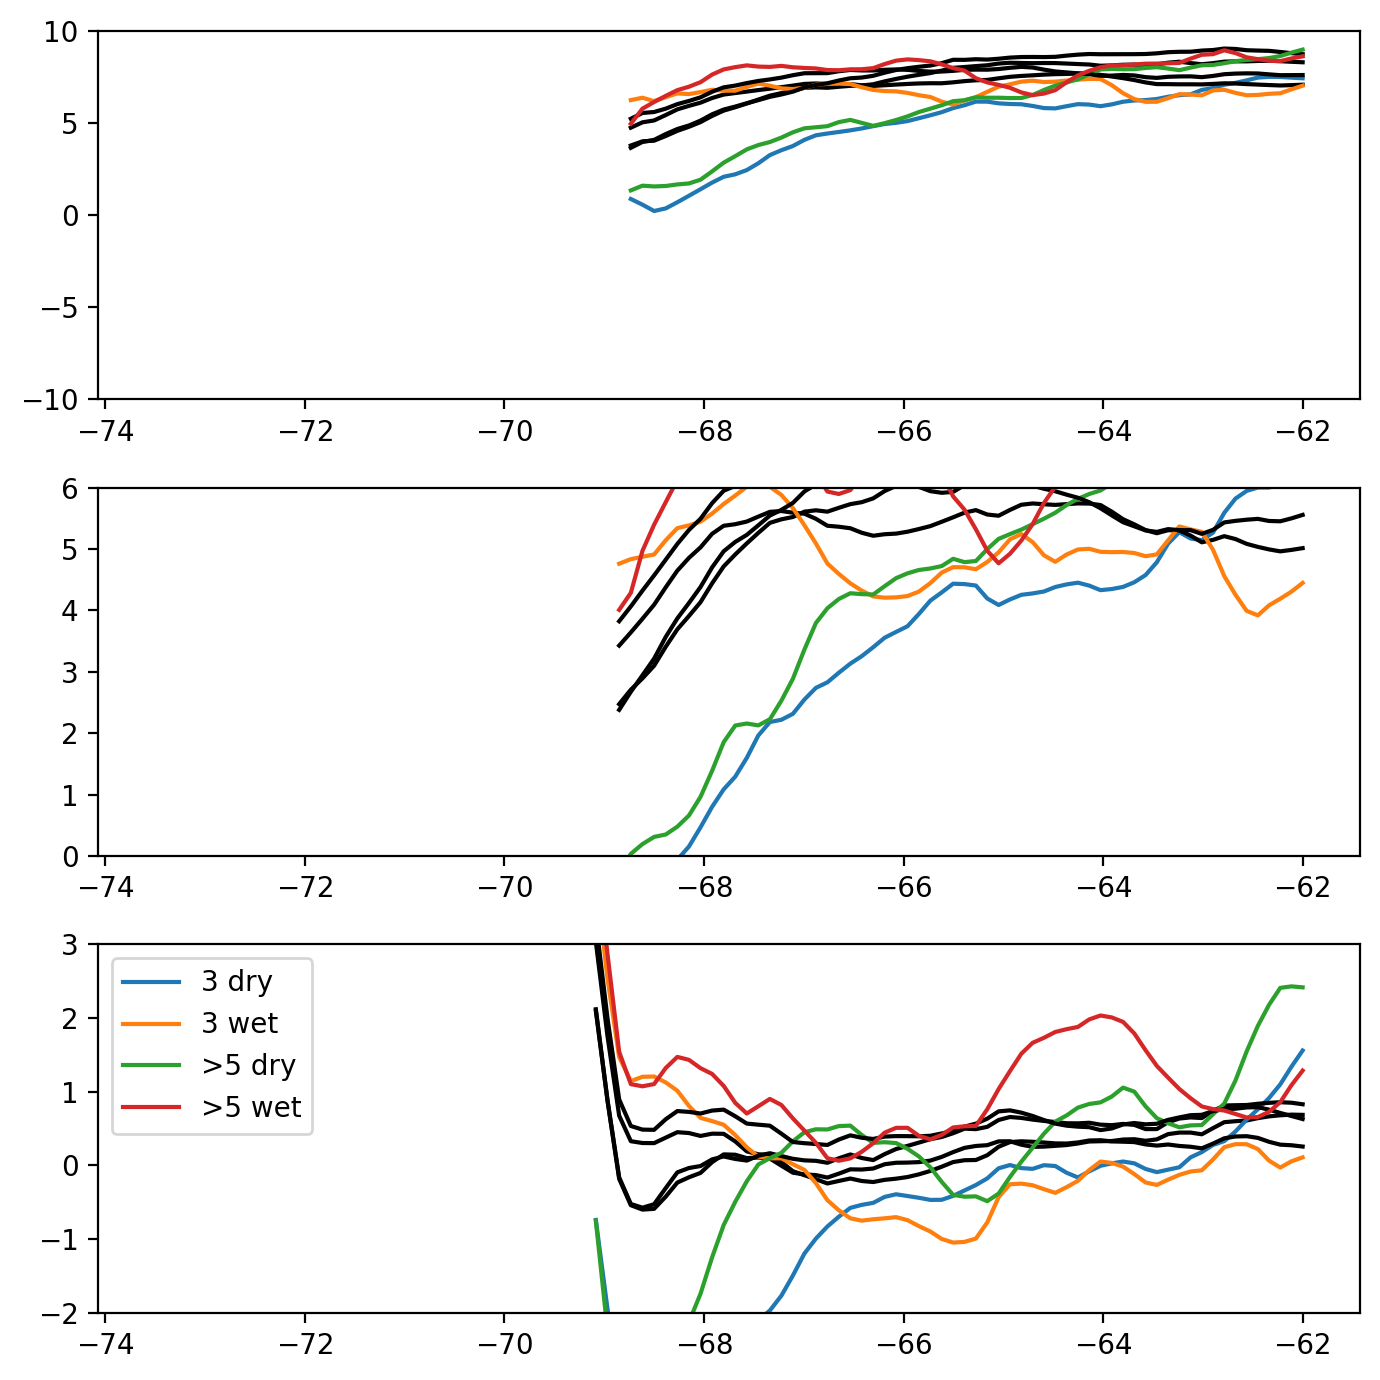

In [47]:
f = plt.figure(figsize=(7,7), dpi=200)

ranges = [(-10,10), (0,6), (-2,3)]

for pan, bi in enumerate([(950,600),(925,600),(850,600)]):
    ax = f.add_subplot(3,1,pan+1)
    
    for ids, tt in enumerate([11,12,1,3,]):

        slices = slices_months[ids][1] # d/w mean
        tag = slices_months[ids][0]
        sli = slices#.isel(month=()) # d/w mean
        slices_ttest = slices_months[ids][2] #  d/w all, for day-wise t-test, all days versus only wet/dry
        slice_clim = slices_months[ids][3] # doy d/w clim

        ul = 600
        dl = 850

        th_es = slices['theta_es'].sel(level=bi[1])
        th_e = slices['theta_e'].sel(level=bi[0])

        th_es_clim = slice_clim['theta_es'].sel(level=bi[1])
        th_e_clim = slice_clim['theta_e'].sel(level=bi[0])

        ax.plot(th_es.longitude, th_e_clim-th_es_clim, color='k')
        ax.plot(th_es.longitude, th_e-th_es, label=tag)

        ax.set_ylim(ranges[pan][0],ranges[pan][1])
        #ax.set_xlim(-74,-66)
plt.tight_layout()
plt.legend()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/cross/'+var+'_drywet_lineplot_'+pregion+'_DoyClim.jpg')

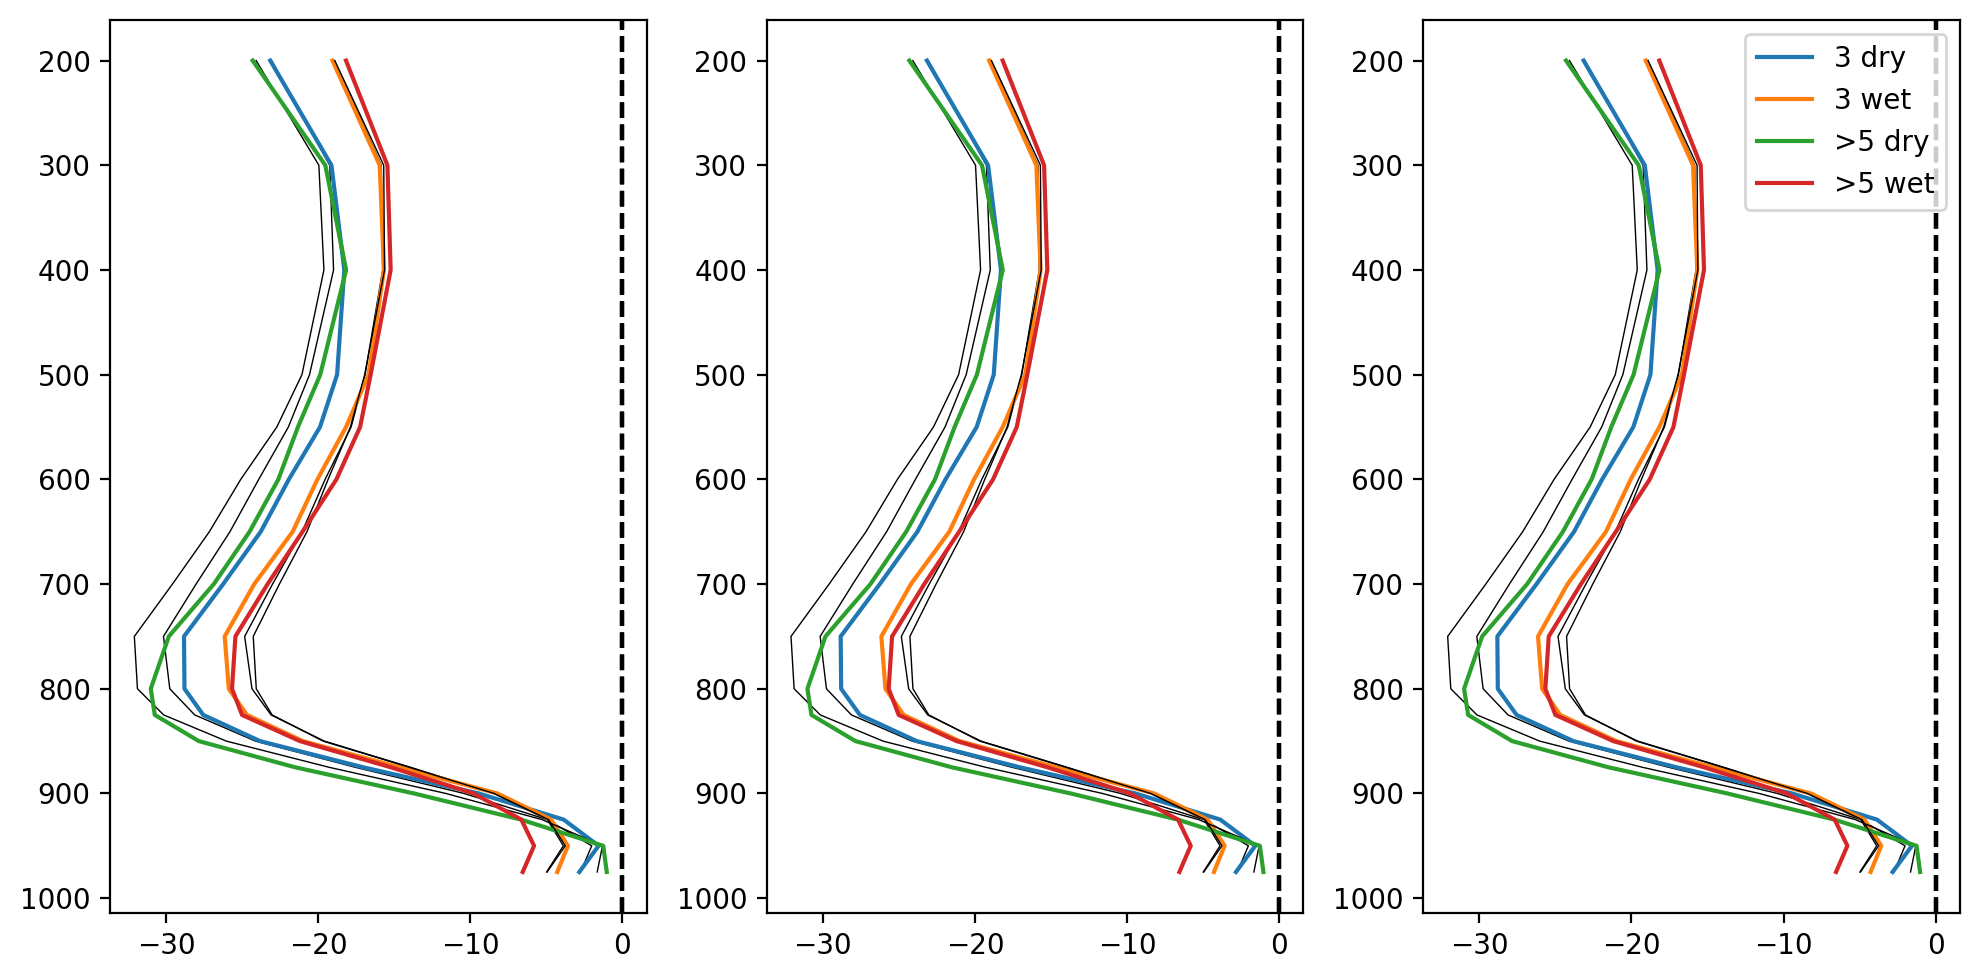

In [48]:
f = plt.figure(figsize=(10,5), dpi=200)

ranges = [(-10,10), (0,6), (-2,3)]

for pan, bi in enumerate([(925,600),(925,600),(925,600)]):
    ax = f.add_subplot(1,3,pan+1)
    plt.gca().invert_yaxis()
    
    for ids, tt in enumerate([11,12,1,3,]):

        slices = slices_months[ids][1] # d/w mean
        tag = slices_months[ids][0]
        sli = slices#.isel(month=()) # d/w mean
        slices_ttest = slices_months[ids][2] #  d/w all, for day-wise t-test, all days versus only wet/dry
        slice_clim = slices_months[ids][3] # doy d/w clim
    

        ul = 600
        dl = 850
        
        lon=-72.5

        th_es = slices['theta_es'].sel( longitude=lon, method='nearest')
        th_e = slices['theta_e'].sel(level=bi[0], longitude=lon, method='nearest')

        th_es_clim = slice_clim['theta_es'].sel(longitude=lon, method='nearest')
        th_e_clim = slice_clim['theta_e'].sel(level=bi[0],longitude=lon, method='nearest')
        
        th_es_cclim = slices_all['theta_es'].sel( longitude=lon, method='nearest')
        th_e_cclim = slices_all['theta_e'].sel(level=bi[0],longitude=lon, method='nearest')

        ax.plot(th_e_clim-th_es_clim, th_es.level,  color='k', linewidth=0.5)
        #ax.plot(th_e_cclim-th_es_cclim, th_e.level,  color='brown')
        ax.plot(th_e-th_es, th_es.level,  label=tag)
        
        ax.axvline(0, linestyle='dashed', color='k')
        

#         ax.set_ylim(ranges[pan][0],ranges[pan][1])
#         ax.set_xlim(-74,-66)

plt.tight_layout()
plt.legend()

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/cross/'+var+'_drywet_lineplot_'+pregion+'_DoyClim.jpg')

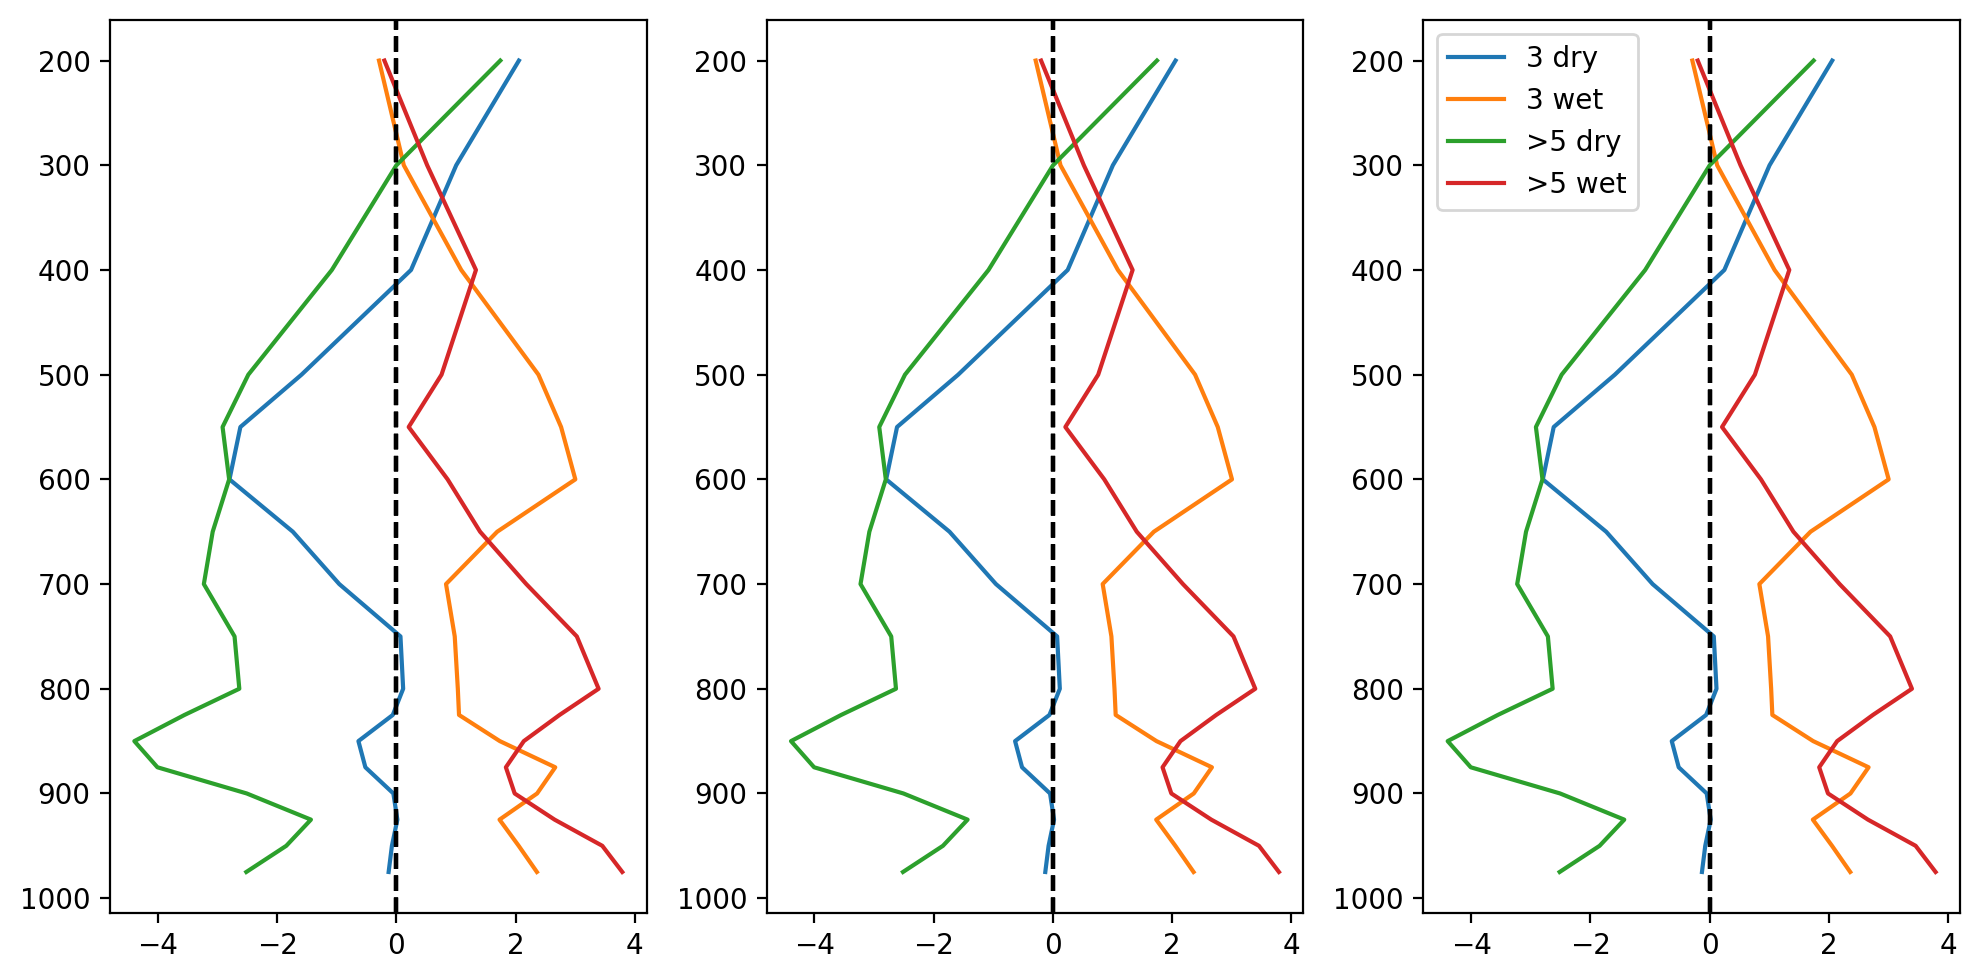

In [49]:
f = plt.figure(figsize=(10,5), dpi=200)

ranges = [(-10,10), (0,6), (-2,3)]

for pan, bi in enumerate([(925,550),(900,550),(850,550)]):
    ax = f.add_subplot(1,3,pan+1)
    plt.gca().invert_yaxis()
    
    for ids, tt in enumerate([11,12,1,3,]):

        slices = slices_months[ids][1] # d/w mean
        tag = slices_months[ids][0]
        sli = slices#.isel(month=()) # d/w mean
        slices_ttest = slices_months[ids][2] #  d/w all, for day-wise t-test, all days versus only wet/dry
        slice_clim = slices_months[ids][3] # doy d/w clim
    

        ul = 600
        dl = 850
        
        lon=-72.5

        th_es = slices['theta_es'].sel(level=bi[1], longitude=lon, method='nearest')
        th_e = slices['theta_e'].sel(longitude=lon, method='nearest')

        th_es_clim = slice_clim['theta_es'].sel(level=bi[1], longitude=lon, method='nearest')
        th_e_clim = slice_clim['theta_e'].sel(longitude=lon, method='nearest')
        
        th_es_cclim = slices_all['theta_es'].sel(level=bi[1], longitude=lon, method='nearest')
        th_e_cclim = slices_all['theta_e'].sel(longitude=lon, method='nearest')

        #ax.plot(th_e_clim-th_es_clim - th_e_cclim-th_es_cclim, th_e.level,  color='k', linewidth=0.5)
        #ax.plot(th_e_cclim-th_es_cclim, th_e.level,  color='brown')
        ax.plot( (th_e-th_es) - (th_e_cclim-th_es_cclim), th_e.level,  label=tag)
        
        ax.axvline(0, linestyle='dashed', color='k')
        

#         ax.set_ylim(ranges[pan][0],ranges[pan][1])
#         ax.set_xlim(-74,-66)

plt.tight_layout()
plt.legend()

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/cross/'+var+'_drywet_lineplot_'+pregion+'_DoyClim.jpg')